In [14]:
import simpy
import math
import random
import tweepy
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [15]:
sufragantes = 6962
ausentismo = 1428
votar_personas = sufragantes + ausentismo
print(votar_personas)

8390


In [16]:
juntasM = 12
juntasF = 13
juntas = juntasM + juntasF
print(juntas)

25


    ◦	Tomar los resultados de la regresión para la vacuna según la llegada.

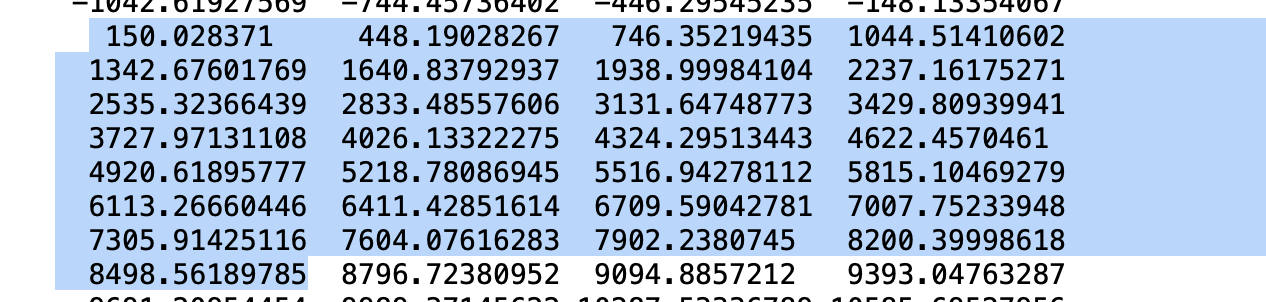

    8498 vacunas en 29 dias
    


In [17]:
vacunas_dia = 8498/(29)
print(vacunas_dia)

293.0344827586207


    ◦	Se tiene una promedio que el 80% de personas realizaran el proceso de vacunación dentro del Ecuador.

In [18]:
promedio80 = (votar_personas * 0.8)
print("80% de personas: ", promedio80)

80% de personas:  6712.0


In [19]:
vacunas = 8498 * 2
print(vacunas)

16996


    ◦	Dentro del procesos se tiene que alrededor del 5% - 10% no podrán vacunarse.

In [20]:
promedio10 = (votar_personas * 0.1)
print("10% de personas: ", promedio10)

10% de personas:  839.0


In [21]:
tiempo_traslado_ambulacion = random.randint(5, 10)
ab = 10
for a in range(10):
    a = random.randint(5, 10)
    print(a)
print(tiempo_traslado_ambulacion)

8
7
9
7
8
5
10
7
9
7
10


    RECUERDA EL HORARIO DE ATENCION EN EL CENTRO DE SALUD ES DE 5:00 A 24:00 

In [32]:
tiempo_verificar = 20
tiempo_vacunacion = random.randint(5, 10)

In [35]:
tiempo_vacunacion_total = tiempo_vacunacion + tiempo_verificar 
print(tiempo_vacunacion_total)

25


In [36]:
# El lugar de vacunacion tiene horario de atencion de 19 horas, en total 1140 minutos
horario_atencion = 60 * (19)
print(horario_atencion)

1140


In [37]:
# Días de vacuna
horario_atencion_completa = horario_atencion * 31
print(horario_atencion_completa)

35340


In [38]:
personas_vacunar = horario_atencion/tiempo_vacunacion_total
personas_vacunar_dia = personas_vacunar*juntas
print(personas_vacunar)
print(personas_vacunar_dia)

45.6
1140.0


In [39]:
intervalo_llegada = horario_atencion/vacunas_dia
print(intervalo_llegada, "en minutos son " , 3)
intervalo_llegada = 3

3.890327135796658 en minutos son  3


In [40]:
aux = 0
atendidos = 0
tiempos_espera = {}
tiempos_llegada = {}
personas_esperando = []
vacunados = 0
no_vacunado = []
horas = []
lista = []

class Recinto(object):
    def __init__(self, environment, num_juntas, tiempo_espera):
        # Guardamos como varible el entorno de ejecución 
        self.env=environment
        # Creamos la varible que representa el numero de juntas para la vacunacion
        self.num_juntas = simpy.Resource(environment, num_juntas)
        # Tiempo de consulta
        self.tiempo_espera = tiempo_espera
        
    # Método que dicta el tiempo que el paciente espera en la fila    
    def espera_paciente(self, paciente):
        espera = random.randint(tiempo_verificar-intervalo_llegada, tiempo_verificar+intervalo_llegada)
        yield self.env.timeout(espera) 
        
    # Translado de la ambulancia    
    def translado_ambulancia(self, paciente):
        espera = random.randint(5, 10)
        yield self.env.timeout(espera)
        
    # Alta medica  
    def alta_medica(self, paciente):
        espera = random.randint(60, 120)
        yield self.env.timeout(espera)
            
def no_vacunarse(paciente, promedio10):
    no_vacuna = random.randint(1,2)
    global aux
    
    if(no_vacuna == 1):
        aux += 1
        if(aux >= promedio10 ):
            no_vacuna = 2
            return no_vacuna
        else :
            return no_vacuna
    else :
        return no_vacuna
        

def llegada_paciente(env, paciente, recinto, no_vacunados):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el paciente con el nombre pasado como parametro
    
   
    global tiempos_llegada
    global vacunados
    
    tiempos_llegada[paciente] = env.now
    
    print("Llega el paciente "+str(paciente)+" a las "+str(env.now))
    
    no_puede_vacurse = no_vacunarse(paciente,promedio10)
    
    # Especificamos que vamos a usar un recurso (Resource) que representa lugar de vacunacion
    with recinto.num_juntas.request() as lugar:
        yield env.process(recinto.espera_paciente(paciente))
        yield lugar
        global atendidos
        
        #usamos try para para agarrar una excepcion
        try:
            tiempos_espera[paciente] = env.now - tiempos_llegada[paciente]
        except:
            a=1
        
        if no_puede_vacurse == 1:

            print("El paciente ",paciente," no puede vacunarse, sale del recinto a las ", (paciente,str(env.now)))
            #y = paciente.replace("Paciente-", "")
            yield env.process(recinto.translado_ambulancia(paciente))
            print("El paciente ",paciente," es traslado en ambulancia ", (paciente,str(env.now)))
            yield env.process(recinto.alta_medica(paciente))
            print("El paciente ",paciente," alta médica ", (paciente,str(env.now)))
            no_vacunado.append(paciente)
            horas.append(int(env.now))
            

def ejecutar_simulacion(env, num_juntas, paciente, intervalo):
    recinto = Recinto(env,num_juntas,tiempo_verificar)
    
    promedio10 = (votar_personas * 0.1)
    
    print("Personas que tienen sintomas: ",promedio10,"%")
    
    for i in range(juntas):
        env.process(llegada_paciente(env,i,recinto,promedio10))
        
    while True:
        yield env.timeout(random.randint(intervalo-intervalo_llegada, intervalo+intervalo_llegada))
        i+=1
        env.process(llegada_paciente(env,i,recinto,promedio10))
        

In [42]:
# Creamos el entorno de simulacion
env=simpy.Environment()
print("Pacientes ", votar_personas)
env.process(ejecutar_simulacion(env, juntas, votar_personas, intervalo_llegada))
# Ejecutamos el proceso durante el tiempo de simulacion

env.run(until = horario_atencion)

Pacientes  8390
Personas que tienen sintomas:  839.0 %
Llega el paciente 0 a las 0
Llega el paciente 1 a las 0
Llega el paciente 2 a las 0
Llega el paciente 3 a las 0
Llega el paciente 4 a las 0
Llega el paciente 5 a las 0
Llega el paciente 6 a las 0
Llega el paciente 7 a las 0
Llega el paciente 8 a las 0
Llega el paciente 9 a las 0
Llega el paciente 10 a las 0
Llega el paciente 11 a las 0
Llega el paciente 12 a las 0
Llega el paciente 13 a las 0
Llega el paciente 14 a las 0
Llega el paciente 15 a las 0
Llega el paciente 16 a las 0
Llega el paciente 17 a las 0
Llega el paciente 18 a las 0
Llega el paciente 19 a las 0
Llega el paciente 20 a las 0
Llega el paciente 21 a las 0
Llega el paciente 22 a las 0
Llega el paciente 23 a las 0
Llega el paciente 24 a las 0
Llega el paciente 25 a las 3
Llega el paciente 26 a las 6
Llega el paciente 27 a las 7
Llega el paciente 28 a las 8
Llega el paciente 29 a las 10
Llega el paciente 30 a las 15
Llega el paciente 31 a las 16
Llega el paciente 32 a l

El paciente  283  no puede vacunarse, sale del recinto a las  (283, '824')
El paciente  279  es traslado en ambulancia  (279, '824')
El paciente  280  es traslado en ambulancia  (280, '825')
Llega el paciente 292 a las 829
El paciente  284  no puede vacunarse, sale del recinto a las  (284, '830')
El paciente  249  alta médica  (249, '831')
Llega el paciente 293 a las 832
El paciente  255  alta médica  (255, '833')
El paciente  285  no puede vacunarse, sale del recinto a las  (285, '833')
El paciente  287  no puede vacunarse, sale del recinto a las  (287, '833')
El paciente  288  no puede vacunarse, sale del recinto a las  (288, '833')
El paciente  283  es traslado en ambulancia  (283, '834')
Llega el paciente 294 a las 836
El paciente  287  es traslado en ambulancia  (287, '838')
El paciente  289  no puede vacunarse, sale del recinto a las  (289, '839')
El paciente  284  es traslado en ambulancia  (284, '840')
Llega el paciente 295 a las 841
El paciente  288  es traslado en ambulancia 

    ◦	Deben calcularse las siguientes métricas del sistema de simulación de eventos discretos :
        ▪	Total de de personas que realizaron el proceso de vacunación.



In [43]:
person_vacunas = vacunados
print("El total de personas que realizaron el proceso de vacunación: ",person_vacunas)

El total de personas que realizaron el proceso de vacunación:  0


     ▪	El 10% de las personas que presentan complicaciones fallecen.

In [52]:
print("Personas que presentan complicaciones fallecen: ",int(promedio10*0.1))

Personas que presentan complicaciones fallecen:  83


        ▪	Grafico del porcentaje de personas que no recibieron la vacuna.


In [44]:
dict = {'Horas':horas, 'No_Vacunacion':no_vacunado} 
df = pd.DataFrame(dict) 
df.to_csv('vacunacion.csv')


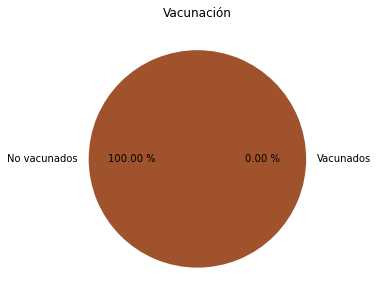

In [45]:
no = len(no_vacunado)
si = vacunados
plt.figure(figsize=(8,5))

etiquetas = ['No vacunados', 'Vacunados']
colores = ['#a0522d', '#aabbcc']
plt.pie([no, si, ], labels=etiquetas, colors=colores, autopct='%.2f %%')
plt.title('Vacunación')
plt.show()

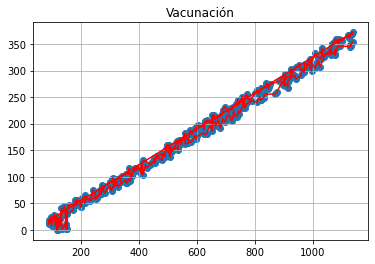

In [46]:
plt.plot(horas,no_vacunado,color='red')
plt.scatter(horas,no_vacunado)
plt.title("Personas con complicaciones en base a las 24 horas")
plt.grid(True)
plt.show()